# <span style= 'color: #7A3803'>Curriculum Engagement and Usage Analysis
## <span style= 'color: #D16002'> Annie Carter's Exploratory Notebook  
- <span style= 'color: #EC9706'> Sourced by CodeUp, LLC

In [56]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import urllib.parse
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
import env
import os
import pandas as pd
from sqlalchemy import create_engine
from io import BytesIO
from io import StringIO
from env import user, hostname, password 

## <span style= 'color: #7A3803'>  ACQUIRE & PREPARE

In [2]:
def get_connection(db, user=env.user, hostname=env.hostname, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{hostname}/{db}'

In [3]:
def get_sql_data():
    '''
    If the CSV file exists, it is read and returned as a pandas DataFrame.
    If not, pandas reads in a SQL query that acquires log data from a MySQL database.
    The query is stored into a DataFrame, saved, and returned.
    '''
    filename = 'curriculum_logs.csv'
    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        # Define SQL query, database parameters, and filename
        sql_query = """
            SELECT l.date, l.time, l.path as lesson, l.user_id, c.name as cohort, c.program_id,
                   l.ip, c.start_date, c.end_date
            FROM logs l
            JOIN cohorts c ON c.id=l.cohort_id;
        """
        db = 'curriculum_logs'
        user = env.user  # Replace with the actual value
        hostname = env.hostname  # Replace with the actual value
        password = env.password  # Replace with the actual value
        
        # Create a database connection using SQLAlchemy
        connection_string = get_connection(db, user, hostname, password)
        engine = create_engine(connection_string)
        
        # Fetch data from the database and convert it into a DataFrame
        logs_df = pd.read_sql(sql_query, get_connection('curriculum_logs'))
        
        # Convert 'date' and 'time' columns to a single 'datetime' column
        logs_df['date'] = pd.to_datetime(logs_df['date'] + ' ' + logs_df['time'])
        logs_df = logs_df.drop(['time'], axis=1)  # Drop 'time' column
        logs_df = logs_df.set_index('date')
        
        # Save the DataFrame as a CSV file
        logs_df.to_csv(filename, index=False)
        
        return logs_df

In [4]:
# Call the function to get and save the data
logs_df = get_sql_data()

In [5]:
logs_df.head()

,lesson,user_id,cohort,program_id,ip,start_date,end_date
0,/,1,Hampton,1,97.105.19.61,2015-09-22,2016-02-06
1,java-ii,1,Hampton,1,97.105.19.61,2015-09-22,2016-02-06
2,java-ii/object-oriented-programming,1,Hampton,1,97.105.19.61,2015-09-22,2016-02-06
3,slides/object_oriented_programming,1,Hampton,1,97.105.19.61,2015-09-22,2016-02-06
4,javascript-i/conditionals,2,Teddy,2,97.105.19.61,2018-01-08,2018-05-17


In [6]:
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847330 entries, 0 to 847329
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lesson      847329 non-null  object
 1   user_id     847330 non-null  int64 
 2   cohort      847330 non-null  object
 3   program_id  847330 non-null  int64 
 4   ip          847330 non-null  object
 5   start_date  847330 non-null  object
 6   end_date    847330 non-null  object
dtypes: int64(2), object(5)
memory usage: 45.3+ MB


In [7]:
logs_df.shape

(847330, 7)

## <span style= 'color: #7A3803'>  EXPLORATION AND ANALYSIS

# <span style= 'color: #D16002'>QUESTION 2
### <span style= 'color: #EC9706'>2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

In [8]:
logs_df['lesson'].nunique()

2224

In [9]:
logs_df['user_id'].nunique()

911

In [10]:
logs_df['cohort'].nunique()

47

In [11]:
def question2_1(logs_df):
    '''This function determines which lesson was most and least refered to by cohort'''
    #Find lesson counts"
    lesson_counts = logs_df.groupby('lesson')[['cohort', 'start_date','user_id']].nunique()
    lesson_counts = lesson_counts.sort_values(by='cohort', ascending=False)
    # Find the lesson that was refered to the most 
    most_referred_cohort = lesson_counts['cohort'].idxmax()
    most_referred_count = lesson_counts.loc[most_referred_cohort, 'cohort']
    
    # Find the lesson that referred to the the least
    least_referred_cohort = lesson_counts['cohort'].idxmin()
    least_referred_count = lesson_counts.loc[least_referred_cohort, 'cohort']
    
    print(f"The lesson that was referred to the the most: {most_referred_cohort} with {most_referred_count} referrals.")
    print(f"The lesson that referred to the the least: {least_referred_cohort} with {least_referred_count} referrals.")
 

In [43]:
question2_1(logs_df)  

The lesson that was referred to the the most: / with 47 referrals.
The lesson that referred to the the least: java-i/loops with 1 referrals.


In [32]:
def question2_2(logs_df):
    '''This function groups data by cohort and lesson to determine the lesson with the highest and lowest counts by cohort'''
    # Group data by cohort and lesson, then calculate the size (count of occurrences)
    cohort2 = logs_df.groupby(['cohort', 'lesson']).size()
    # Reset the index and rename the count column
    cohort2 = cohort2.reset_index(name='count')
    # Filter the DataFrame to show only the rows where lesson is '/' and  count in descending order
    cohort2 = cohort2.loc[cohort2['lesson'] == '/'].sort_values(by='count', ascending=False)
    return cohort2.head(), cohort2.tail()

In [33]:
question2_2(logs_df)

(          cohort lesson  count
 9500       Staff      /   6340
 2891      Darden      /   2980
 11855  Voyageurs      /   2101
 4262     Fortuna      /   2038
 1304       Bayes      /   1967,
           cohort lesson  count
 5647      Joshua      /      8
 4520    Franklin      /      4
 3598      Denali      /      1
 639       Apollo      /      1
 4099  Everglades      /      1)

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

def question2_2graph(logs_df):
    '''This function groups data by cohort and lesson to determine the lesson with the highest and lowest counts by cohort'''
    # Group data by cohort and lesson, then calculate the size (count of occurrences)
    cohort2 = logs_df.groupby(['cohort', 'lesson']).size()
    # Reset the index and rename the count column
    cohort2 = cohort2.reset_index(name='count')
    # Filter the DataFrame to show only the rows where lesson is '/' and  count in descending order
    cohort2 = cohort2.loc[cohort2['lesson'] == '/'].sort_values(by='count', ascending=False)
    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(data=cohort2, x='cohort', y='count', palette='Oranges')
    plt.xlabel('Cohort')
    plt.ylabel('Lesson / Count')
    plt.title('Lesson with Highest Count by Cohort')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



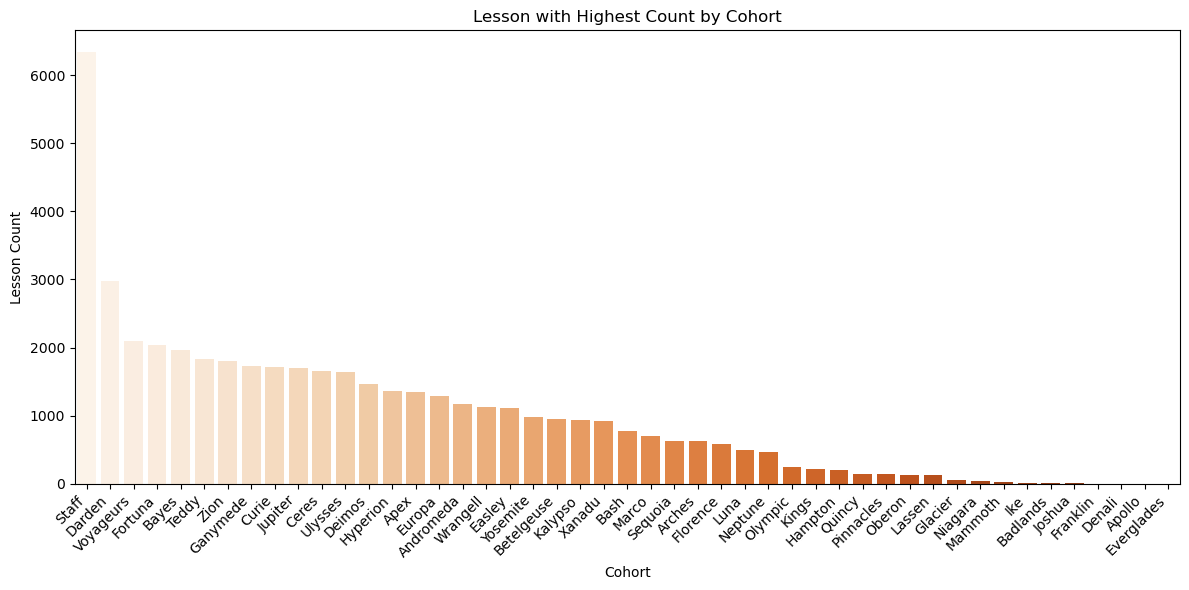

In [54]:
# Call the function with your logs_df DataFrame
question2_2(logs_df)

# <span style= 'color: #D16002'>QUESTION 2 Findings:
###  <span style= 'color: #EC9706'>The homepage marked as "/" received the highest number of accesses. Remarkably, the "Darden" cohort, aside from "Staff," exhibited a substantial engagement with this lesson, accessing it a notable 2980 times. This count surpassed the single access recorded for the Denali, Apollo, and Everglades cohorts.

#### Codes that were used on the way to answer Q2

In [14]:
# cohort2 = logs_df.groupby(['cohort', 'lesson']).size()
# cohort2 = cohort2.reset_index(name='count')
# cohort2 = cohort2.sort_values(by='count', ascending=False)
# cohort2 = corhort2.iloc('/').sort_values
# cohort2



In [15]:
# # let's observe unique hits based on cohort
# cohort_counts = logs_df.groupby('cohort')[['user_id', 'start_date','lesson']].nunique()
# cohort_counts 

In [16]:
# let's observe unique hits based on cohort
lesson_counts = logs_df.groupby('lesson')[['cohort', 'start_date','user_id']].nunique()
lesson_counts = lesson_counts.sort_values(by='cohort', ascending=False)
lesson_counts 

,cohort,start_date,user_id
lesson,,,
/,47,44,894
search/search_index.json,41,38,651
toc,40,39,624
java-i,40,39,599
html-css,40,39,680
...,...,...,...
appendix/testing-code.md,1,1,1
appendix/spring/seeder,1,1,1
appendix/spring/security-use-cases,1,1,1


In [17]:
# lesson_result = logs_df.groupby([logs_df.index])[['cohort','lesson','user_id']].nunique('lesson')
# lesson_result = result.sort_values(by='lesson', ascending=False)
# lesson_result

In [18]:
# cohort_counts = logs_df.groupby(['cohort', 'lesson']).value_counts()
# cohort_counts = cohort_counts.sort_values(by='lesson', ascending=False)


# # cohort = logs_df.groupby(['cohort'])[['lesson']].nunique('lesson')
# # cohort = cohort.reset_index(name='count')
# # cohort = cohort.sort_values(by='count', ascending=False)
# cohort_counts

In [19]:

# logs_df.groupby(['index'/date])[[ cohort 'lesson', 'user_id']].nunique()sort.('name'ascending, False)
result = logs_df.groupby([logs_df.index])[['cohort','lesson','user_id']].nunique('lesson')
result = result.sort_values(by='lesson', ascending=False)
result

,cohort,lesson,user_id
0,1,1,1
564891,1,1,1
564881,1,1,1
564882,1,1,1
564883,1,1,1
...,...,...,...
282448,1,1,1
282449,1,1,1
282450,1,1,1
847329,1,1,1


In [20]:
result.head()

,cohort,lesson,user_id
0,1,1,1
564891,1,1,1
564881,1,1,1
564882,1,1,1
564883,1,1,1


In [21]:
result.tail()

,cohort,lesson,user_id
282448,1,1,1
282449,1,1,1
282450,1,1,1
847329,1,1,1
478630,1,0,1


In [22]:
page_views = logs_df.groupby(['cohort'])['lesson'].agg(['count', 'nunique'])

## <span style= 'color: #D16002'> QUESTION 3
### <span style= 'color: #EC9706'>3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?


In [23]:

# logs_df.groupby(['index'/date])[[ cohort 'lesson', 'user_id']].nunique()sort.('name'ascending, False)
result2 = logs_df.groupby(['user_id'])[['lesson','ip']].nunique('lesson')
result2 = result2.sort_values(by='ip', ascending=False)
result2

,lesson,ip
user_id,,
228,145,148
843,137,126
533,156,92
690,185,88
530,158,86
...,...,...
758,29,1
24,16,1
765,147,1


In [24]:
student = logs_df.groupby(['user_id', 'lesson']).value_counts()
student = student.reset_index(name='count')
student = student.sort_values(by='count', ascending=False)
# cohort3 = iloc('/').sort_values
student

,user_id,lesson,cohort,program_id,ip,start_date,end_date,count
4313,11,/,Staff,2,97.105.19.58,2014-02-04,2014-02-04,571
85064,428,jquery/ajax/weather-map,Staff,2,70.121.183.95,2014-02-04,2014-02-04,529
14146,53,index.html,Lassen,1,97.105.19.58,2016-07-18,2016-11-10,501
15453,64,/,Staff,2,71.150.217.33,2014-02-04,2014-02-04,448
4314,11,/,Staff,2,76.185.145.231,2014-02-04,2014-02-04,407
...,...,...,...,...,...,...,...,...
80747,414,javascript-i/loops,Betelgeuse,2,66.25.166.124,2019-05-28,2019-10-08,1
80746,414,javascript-i/loops,Betelgeuse,2,68.206.254.17,2019-05-28,2019-10-08,1
80745,414,javascript-i/loops,Betelgeuse,2,76.185.135.244,2019-05-28,2019-10-08,1
80743,414,javascript-i/javascript-with-html,Betelgeuse,2,68.206.254.17,2019-05-28,2019-10-08,1
